# ORTHOGONAL POLYNOMIAL DENSITY ESTIMATION
## Preliminaries
### Imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sbn
import numpy as np
import numpy.polynomial.legendre as npl

from scipy.optimize import minimize

### Notebook settings

In [2]:
%matplotlib notebook
sbn.set_style('white')

legend_params = {'loc': 'best',
                 'frameon': True, 
                 'fancybox': True, 
                 'framealpha': 0.7}

## Create Synthetic Data

<IPython.core.display.Javascript object>


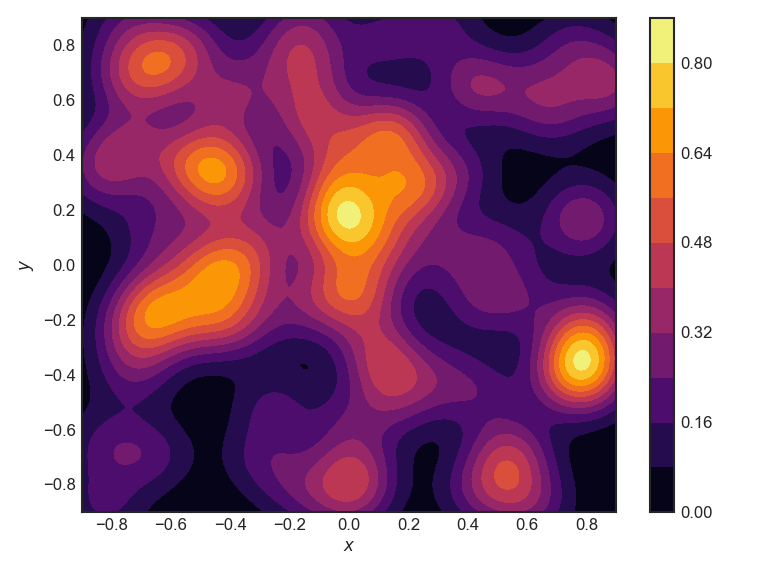

In [3]:
N = 100

#x, y = np.random.multivariate_normal((0,0), ((0.1,0), (0,0.1)), size=N).T
x = np.random.uniform(low=-0.9, high=0.9, size=N)
y = np.random.uniform(low=-0.9, high=0.9, size=N)

fig, ax = plt.subplots()
sbn.kdeplot(x, y, shade=True, gridsize=250, bw=(0.1, 0.1), ax=ax, cmap='inferno', cbar=True)
ax.set(xlabel=r'$x$', ylabel=r'$y$', xlim=(-0.9, 0.9), ylim=(-0.9, 0.9))
fig.tight_layout()

## Maximum Likelihood Estimate of the Density
### Initialize Legendre polynomials
Choose polynomial degrees $I$ and $J$, initialize coefficients $\mathbf{c}$, and compute basis-function values at all values of $x$ and $y.

In [4]:
I = 10
J = 10

c = np.random.uniform(low=-0.1, high=0.1, size=(I+1)*(J+1))
c /= c.dot(c)
c = np.zeros((I+1)*(J+1))
c[0] = 1
c = np.append(c, N)
#x= 0.5
#y = 0.5

norm = np.array([[np.sqrt(2/(2*i + 1))*np.sqrt(2/(2*j + 1)) for j in range(J+1)] for i in range(I+1)])
phi_ijn = npl.legvander2d(x, y, (I, J)).T / norm.ravel()[:, np.newaxis]

### Likelihood and constraint

In [6]:
def neglogl(c):
    return -np.log(np.square(c.dot(phi_ijn))).sum()

def grad_neglogl(c):
    return -2*(phi_ijn / c.dot(phi_ijn)).sum(axis=1)

def normalization(c):
    return c.dot(c) - 1

def grad_normalization(c):
    return 2*c

constraint = {'type': 'eq',
              'fun': normalization,
              'jac': grad_normalization}

option = {'maxiter': 5000}

### Compound objective function

In [7]:
hess = np.zeros(((I+1)*(J+1)+1, (I+1)*(J+1)+1))
ones = np.eye((I+1)*(J+1))

def objective(c):
    return -np.log(np.square(c[:-1].dot(phi_ijn))).sum() + c[-1]*(c[:-1].dot(c[:-1]) - 1)

def grad_objective(c):
    return np.append(-2*(phi_ijn / c[:-1].dot(phi_ijn)).sum(axis=1) + 2*c[-1]*c[:-1], c[:-1].dot(c[:-1]) - 1)

def hess_objective(c):
    hess[:-1, :-1] = (2*(np.einsum('i...,j...', phi_ijn, phi_ijn) / 
                         np.square(c[:-1].dot(phi_ijn)[:, np.newaxis, np.newaxis])).sum(axis=0)
                      + 2*c[-1]*ones)
    hess[:-1, -1] = hess[-1, :-1] = 2*c[-1]*c[:-1]
    return hess

In [8]:
def objective(c):
    l = np.append(-2*(phi_ijn / c[:-1].dot(phi_ijn)).sum(axis=1) + 2*c[-1]*c[:-1], c[:-1].dot(c[:-1]) - 1)
    return l.dot(l)

def grad_objective(c):
    sqrt_p = c[:-1].dot(phi_ijn)
    sqs = c[:-1].dot(c[:-1])
    phi_over_sqrt_p = phi_ijn / sqrt_p
    phi_over_p = phi_over_sqrt_p / sqrt_p
    first = (2*c[-1]**2 + sqs - 1)*c[:-1]
    second = c[-1]*(phi_over_p*(1 - 2*sqrt_p)).sum(axis=1)
    #third = phi_over_p.dot(np.einsum('ij,ik->j', phi_over_sqrt_p, phi_over_sqrt_p))
    third = phi_over_p.dot(np.tensordot(phi_over_sqrt_p, phi_over_sqrt_p, ((0,),(0,))).sum(axis=0))
    last = 8*(c[-1]*sqs - N)
    return np.append(4*(first+second-third), last)

### Direct optimization of compound objective function

In [9]:
#%%timeit
res_direct = minimize(objective, c, method='l-bfgs-b', jac=grad_objective)#, hess=hess_objective)
res_direct.x[:-1].dot(res_direct.x[:-1])

1.0000323073757695

In [ ]:
2*(np.einsum('i...,j...', phi_ijn, phi_ijn) / c[:-1].dot(phi_ijn)[:, np.newaxis, np.newaxis]).sum(axis=0) + 2*c[-1]*np.eye(())

In [ ]:
%%timeit
phi_over_p.dot(np.tensordot(phi_over_sqrt_p, phi_over_sqrt_p, ((0,),(0,))).sum(axis=0))

In [ ]:
%%timeit
phi_over_p.dot(np.einsum('ij,ik->j', phi_over_sqrt_p, phi_over_sqrt_p))

In [ ]:
sum(np.outer(phi_ijn[:, n], phi_ijn[:, n]) / np.square(sqrt_p_hat[n]) for n in range (N))

In [ ]:
(np.einsum('i...,j...', phi_ijn, phi_ijn) / np.square(c[:-1].dot(phi_ijn))[:, np.newaxis, np.newaxis]).sum(axis=0)

In [ ]:
denom = (1 / np.square(c[:-1].dot(phi_ijn)))

In [ ]:
sqrt_p_hat = res_constrained.x.dot(phi_ijn)
np.linalg.norm((phi_ijn / sqrt_p_hat).sum(axis=1))

### Contrained minimization of negative log-likelihood

In [12]:
#%%timeit
res_constrained = minimize(neglogl, c[:-1], method='slsqp', jac=grad_neglogl, constraints=constraint, options=option)
res_constrained.x.dot(res_constrained.x)

1.0000000515563452

In [14]:
res_constrained

     fun: -7.342686861888759
     jac: array([-7.0252901 , -0.92543868,  2.73565913, -0.86025655, -0.28954167,
        1.6583767 ,  1.51265091, -0.65247408,  0.32175189,  2.33734082,
       -2.02448879,  2.65912555,  0.37096977, -4.43274594, -1.64967976,
        2.28126918,  0.61235327,  1.96407465,  1.71301558, -1.67381728,
       -0.2646592 , -0.35098948,  1.24801827, -0.19828097,  0.10478513,
        1.77244544,  0.15193923, -2.22351008, -1.41813272,  1.3457053 ,
        0.60656053, -2.0244372 , -0.04582324, -0.13649281,  0.02203471,
        3.36707875,  1.79167199, -1.97930455, -0.48431411, -2.22321673,
       -2.85850398,  0.27399831,  0.75469484,  2.82256311,  2.76815112,
        1.76993962,  0.14095203, -2.35980986, -1.84150962,  2.22275271,
        0.02969775, -1.89667606,  0.83664895,  0.23626804, -0.51784981,
       -2.50125337, -1.31888133,  0.22949076,  0.57817485,  0.33217829,
       -0.62424826,  0.25807771,  1.70016538,  1.61737689,  0.12565148,
       -2.03905648, -0.54

In [1]:
from scipy.optimize import fmin_slsqp, fmin_l_bfgs_b

In [56]:
x = fmin_slsqp(neglogl, c[:-1], 
           eqcons=(lambda c: c.dot(c) - 1,),
           fprime=grad_neglogl,
           fprime_eqcons=lambda c: 2*c)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 116.70977375442297
            Iterations: 97
            Function evaluations: 325
            Gradient evaluations: 97


In [58]:
x.dot(x)

1.0000000424462965

In [59]:
x, value, status = fmin_l_bfgs_b(objective, c, grad_objective)

In [60]:
grad_objective(x).dot(grad_objective(x))

1.6210602263543652e-05

In [63]:
x[:-1].dot(x[:-1])

1.0000012371859313

In [ ]:
res_constrained.x - res_direct.x[:-1]

### Plot comparative results
The estimated density is evaluated on a uniform grid.

<IPython.core.display.Javascript object>


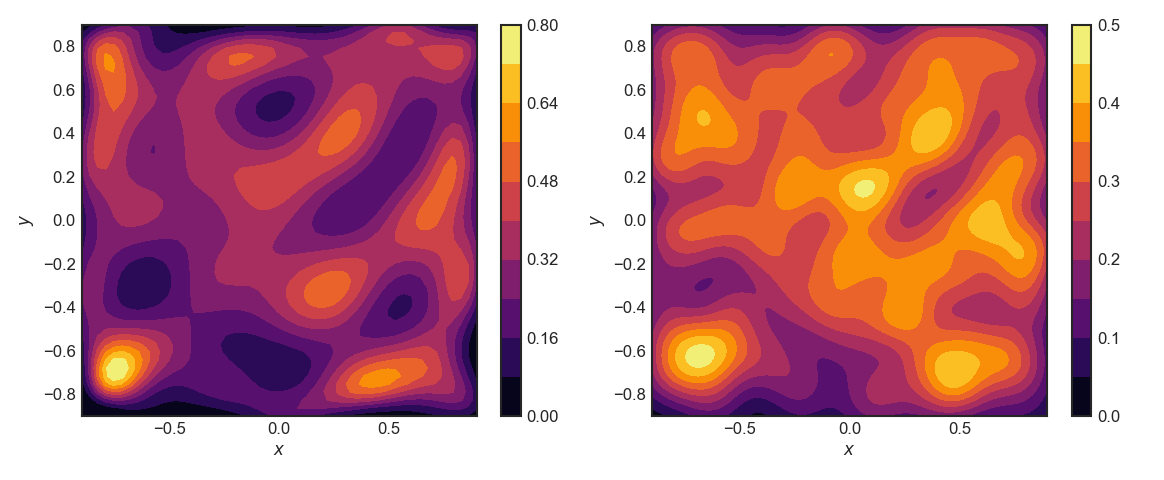

In [21]:
x_grid = np.linspace(-0.9, 0.90, 50)
y_grid = np.linspace(-0.9, 0.90, 50)
x_grid, y_grid = np.meshgrid(x_grid, y_grid)
phi_ijn_grid = npl.legvander2d(x_grid.ravel(), y_grid.ravel(), (I, J)).T / norm.ravel()[:, np.newaxis]
p = np.square(res_direct.x[:-1].dot(phi_ijn_grid)).reshape((50, 50))

fig, (lax, kax) = plt.subplots(1, 2, figsize=(9.7, 4))
lax.set(xlabel=r'$x$', ylabel=r'$y$')
contour = lax.contourf(x_grid, y_grid, p, 9, cmap='inferno')
cbar = plt.colorbar(contour, ax=lax)
sbn.kdeplot(x, y, shade=True, gridsize=250, bw=(0.1, 0.1), ax=kax, cmap='inferno', cbar=True)
kax.set(xlabel=r'$x$', ylabel=r'$y$', xlim=(-0.9, 0.9), ylim=(-0.9, 0.9))
fig.tight_layout()

## Density Gradient

In [ ]:
coeffs_of_grad_x = npl.legder(res_direct.x.reshape((I+1, J+1))/norm, axis=0)
coeffs_of_grad_y = npl.legder(res_direct.x.reshape((I+1, J+1))/norm, axis=1)

grad_x = 2*(npl.legval2d(x_grid, y_grid, res.reshape((I+1, J+1))/norm)*
            npl.legval2d(x_grid, y_grid, coeffs_of_grad_x))
grad_y = 2*(npl.legval2d(x_grid, y_grid, res.reshape((I+1, J+1))/norm)*
            npl.legval2d(x_grid, y_grid, coeffs_of_grad_y))

fig, ax = plt.subplots(figsize=(5.5, 5),)
ax.quiver(x_grid, y_grid, grad_x, grad_y, p, angles='xy', pivot='middle', cmap='inferno')
ax.contour(x_grid, y_grid, p, 9, cmap='inferno', linewidths=1.0)
ax.set(xlabel=r'$x$', ylabel=r'$y$', xlim=(-0.9, 0.9), ylim=(-0.9, 0.9), facecolor='k')
fig.tight_layout()